# Multi-variate linear regression

## 1. Definition and parameter estimation

As we remember linear model between single real-value regressor $x$ and output variable $y$ is expressed by 
$$
y=w_1 x + w_0 +\varepsilon.
$$
$w_1$-slope coefficient, $w_0$ - intercept, $\varepsilon$ - random noise. In a more general case when $x$ is a real-valued $n \times 1$-vector $x=(x_1,x_2,...,x_n)^T$, the model could be easily generalized as
$$
y=\sum\limits_j w_j x_j +\varepsilon
$$
or in a vector form
$$
y=w^T x+\varepsilon, \hspace{5ex} (1)
$$
where $w=(w_1,w_2,...,w_n)$ is also a $n \times 1$-vector. 
Notice that intercept is not specifically separated as it could be always introduced by adding a dummy variable $x^m\equiv 1$.

The probabilistic view on the model in the assumption that $\varepsilon\sim {\cal N}(0,\sigma^2)$ is
$$
p(y|x,w,\sigma)={\cal N}(y|w^T x,\sigma^2).
$$

Given a training set $X=\{(x_j^i), j=1..n, i=1..N\}$, $Y=\{(y^i), i=1..N\}$ (further also denote columns of $X$ as $X_j=\{(x_j^i), i=1..N\}$), the least square optimization criteria for inferring a vector of coefficients $w$ can be written as

$$
RSS(w)= \sum \limits_i \varepsilon_i^2= \sum \limits_i (y^i-w^T x^i)^2. \hspace{5ex} (2)
$$

or in a matrix form:
$$
RSS(w)=(Y-X w)^T(Y-X w).
$$
Then finding an estimate
$$
\hat{w}=argmin_w RSS(w)
$$
can be done by solving the system (in a matrix form)
$$
0=\frac{\partial RSS(\hat{w})}{\partial w}=2X^T (Y-X \hat{w}).
$$
Using matrix formalism the solution could be expressed as
$$
\hat{w}=\left(X^T X\right )^{-1}X^T Y. \hspace{5ex} (3)
$$
This assumes that $X^T X$ is non-singular. Otherwise we have a case of multicollinearity.

## 2. Regression performance: R-squared

In the same way as for the bi-variate regression:
$$
R^2=1-\frac{RSS}{\sum\limits_i (y_i-\overline{y})^2}=\frac{\sum\limits_i (\hat{y}_i-\overline{y})^2}{\sum\limits_i (y_i-\overline{y})^2},
$$
where $\overline{y}=\sum\limits_i y_i$ is the sample mean of observed values of responce variable, while $\hat{y}_i=w^T x_i$ is the predicted value of output variable as compared to the observed value of $y_i$ corresponding to $x=x_i$. This way $R^2$ is often interpreted as a fraction of responce variable's variance explained by linear model. $R^2=1$ is equivalent to $RSS=0$, i.e. the model fits the observations exactly, i.e. responce variable depends linearly on the explaining variables. On the other hand, $R^2=0$ means that the model always predicts the sample mean $\overline{y}$, i.e. explaining variables $x$ have no effect on responce variable $y$. 

Least-square criteria is equivalent to maximizing $R^2$.

In case of a bi-variate regression with intercept $R^2=corr(Y,X)^2$, i.e. is a square of a correlation coefficient between observations of input and output variables.

# Use case - urban mobility
Recall the use case from the first class where we analyzed and visualized spatial distribution of urban population - residential and working. As we saw those tell pretty different stories and might not be well suited to represent urban activity at any given moment in time. 

Now consider a dataset with actual observations of such activity as seen through various data sources. The data contain cumulative number of 1) taxi+Uber pick-ups/drop-offs, 2) CitiBike pick-ups/drop-offs, 3) subway (MTA) extries and exits, 4) volume of 311 service requests, 5) cumulative activity in various mobile apps,  and 6) number of geo-tagged tweets. 

1)-4) is NYC open data, 5) is collected from http://skyhook.carto.com/ and 6) - scraped using Twitter Open API.

All data is aggregated temporally over one month of July, 2017 and spatially per taxi zone. It is also supplemented with the aggregated Census data reflecting amount and structure of residential population. 

**In this analysis we ask a question on what type of population contributes more to each type of activity - residential or working?**

More analysis using these data could be found in our recent pre-print at https://arxiv.org/abs/1809.01280

In [42]:
#import all necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn

%matplotlib inline
pd.set_option('display.max_columns',500)

In [2]:
#Upload the main dataset
SMdata=pd.read_csv("SMdata/Socio-mobility.csv",index_col=0)

In [3]:
SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,9.031957,8.955406,NaN,NaN,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40


In [4]:
#replace NaN's with zeros
SMdata.fillna(0,inplace=True); SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,9.031957,8.955406,0.000000,0.000000,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40


In [5]:
#also upload two other datasets from the last class - residential and working population
LEHDW=pd.read_csv("SMdata/LEHD-work.csv",index_col=0)

In [6]:
#notice that residetial population here (from LEHD, based on the workforce residences) 
#is different from the one in the main dataset 
LEHDR=pd.read_csv("SMdata/LEHD-resident.csv",index_col=0)

In [7]:
LEHDR.head()

,total,male,female,age_under_29,age_30_54,age_55_over,white,black,asian,others,two_or_more,less_high_school,high_school,college,bachelor
tz,,,,,,,,,,,,,,,
2,198,108,90,67,70,61,104,45,29,8,12,24,31,38,38
3,11398,5393,6005,2551,6346,2501,5990,4106,973,120,209,1414,2035,2666,2732
4,12318,6125,6193,3731,6421,2166,8259,2063,1591,122,283,1375,1859,2392,2961
5,10751,5546,5205,2154,6057,2540,9513,464,656,36,82,792,1626,2466,3713
6,6729,3287,3442,1409,3692,1628,5093,677,818,53,88,582,1052,1538,2148


In [8]:
#merge the dataframes (inner merge on index - taxi zone number)
SMdata=SMdata.merge(LEHDW, on=None, left_index=True, right_index=True, how='inner', suffixes=('','LW'))

In [9]:
SMdata=SMdata.merge(LEHDR, on=None, left_index=True, right_index=True, how='inner', suffixes=('','LR'))

In [10]:
SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,age_55_overLR,whiteLR,blackLR,asianLR,othersLR,two_or_moreLR,less_high_schoolLR,high_schoolLR,collegeLR,bachelorLR
tz,,,,,,,,,,,,,,,,,,,,,
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,2501,5990,4106,973,120,209,1414,2035,2666,2732
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,2166,8259,2063,1591,122,283,1375,1859,2392,2961
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,2540,9513,464,656,36,82,792,1626,2466,3713
6,15896.0,7362.0,8534.0,18.709135,19.244451,33.422632,28.623782,74.068948,6.831907,12.833417,...,1628,5093,677,818,53,88,582,1052,1538,2148
7,77252.0,37588.0,39664.0,10.915257,25.508724,41.765888,21.810130,64.901880,5.006990,16.789209,...,6985,32818,3975,5114,334,807,3928,6312,8477,12554


In [11]:
SMdata.columns

Index([u'population', u'male', u'female', u'age_under_14', u'age_15_29',
       u'age_30_54', u'age_55_over', u'white', u'black', u'asian', u'others',
       u'two_or_more', u'less_high_school', u'high_school', u'college',
       u'bachelor', u'graduate', u'median_income_households',
       u'median_income_families', u'median_income_nonfamily',
       u'mean_income_households', u'mean_income_families',
       u'mean_income_nonfamily', u'percent_below_poverty',
       u'unemployment_rate', u'percent_uninsured', u'mean_price_per_sqft',
       u'median_price_per_sqft', u'citibike_spatial', u'mobile-device_spatial',
       u'sr311_spatial', u'subway_spatial', u'taxi_spatial',
       u'twitter_spatial', u'total', u'maleLW', u'femaleLW', u'age_under_29',
       u'age_30_54LW', u'age_55_overLW', u'whiteLW', u'blackLW', u'asianLW',
       u'othersLW', u'two_or_moreLW', u'less_high_schoolLW', u'high_schoolLW',
       u'collegeLW', u'bachelorLW', u'totalLR', u'maleLR', u'femaleLR',
       u'age_

In [12]:
#rename some of the columns for the sake of consistency and also to replace '-'
SMdata.rename(columns={'total':'totalLW','mobile-device_spatial':'mobile_spatial'},inplace=True)

In [13]:
#auxiliary function to compute correlations between columns where both have data
def NZPopCorr(col1,col2):
    ind=(SMdata[col1]>0)&(SMdata[col2]>0)
    return np.corrcoef(SMdata[col1][ind],SMdata[col2][ind])[0][1]

In [14]:
NZPopCorr('totalLW','totalLR')

-0.040785549097983244

In [15]:
#output a table with correlations between activities and population counts
PL=['population','totalLR','totalLW']
Act=['taxi_spatial','subway_spatial','citibike_spatial','twitter_spatial','mobile_spatial','sr311_spatial']
print('\tActivity | {}\t | {}\t | {}\t |'.format(PL[0],PL[1],PL[2]))
for A in Act:
    C=[]
    for P in PL:
        C+=[NZPopCorr(A,P)]   
    print('%16s | %.4f\t | %.4f\t | %.4f\t |'% (A,C[0],C[1],C[2]))    

	Activity | population	 | totalLR	 | totalLW	 |
    taxi_spatial | -0.0647	 | 0.0496	 | 0.7196	 |
  subway_spatial | -0.2325	 | -0.1417	 | 0.7206	 |
citibike_spatial | -0.1270	 | 0.0112	 | 0.3190	 |
 twitter_spatial | -0.0326	 | 0.0178	 | 0.6265	 |
  mobile_spatial | 0.6766	 | 0.6467	 | 0.1757	 |
   sr311_spatial | 0.8695	 | 0.8634	 | -0.0561	 |


So transportation activity and twitter are correlated more with working population, while mobile device and 311 - with residential.

**Now visualize the spatial distribution of activites comparing against residential and working population**

In [16]:
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

tzs = shp.Reader('taxi_zones/taxi_zones.shp')
tzs_records=tzs.records()
tzs_shape=tzs.shapeRecords()

In [17]:
#implement a function for heatmap visualization of attributes of taxi zones provided through a dataframe df
import math
def plot_on_map(shp,df,column,areaNorm=False,logScale=False):
    #take shapefile as shp, dataframe as df, a column to visualize and two flags on whether to normalize by area and to take log scale
    
    #shortcuts for accessing records and points of the shapes
    shp_records=shp.records()
    shp_shape=shp.shapeRecords()
    
    x = {} #dictionary for values to visualize for each key - create it below
    
    for tz in df.index:
        key=tz
        x[key]=df[column][tz]

    y = {} #normalized version of the values now assigned to each shape already
    for s in range(0,len(shp_records)):
        z=int(shp_records[s][0])
        if z in x.keys(): 
            x_ = x[z]
            if areaNorm:
                x_ = x_ / float(shp_records[s][2])
            if logScale:
                x_ = math.log( x_+(x_==0))
            y[z] = x_    
                
    #min-max values            
    maxY=max(y.values())
    minY=min(y.values())
    
    if logScale: #if log-scale limit the scale to the values no lower than exp(-3)~0.04 of the max
        minY=maxY-3
    
    #prepare colormap
    cbins=20; #number of colorscale bins
    cmap = plt.cm.cool(np.linspace(0,1,cbins+1))
    #plot new figure
    fig = plt.figure(figsize = (12,15)) 
    ax = fig.gca()
    
    #visualize each shape with the color depending on the value 
    for s in range(0,len(shp_records)): #for all shapes
        z=int(shp_records[s][0]) #take the shape id
        if z in y.keys(): #if it has a corresponding value       
            k=int(cbins*(y[z]-minY)/(maxY-minY)) #pick up a color based on a value
            if k<0: #truncate negatives (can occur in log-scale due to sclae limitation)
                k=0
            c=cmap[k][0:3] #get the RGB color  
            #get x,y of the shape
            shape=shp_shape[s]
            x_ = [i[0] for i in shape.shape.points[:]]
            y_ = [i[1] for i in shape.shape.points[:]]
            #plot a polygon of that shape
            poly=Polygon(zip(x_,y_))
            ax.add_patch(PolygonPatch(poly, fc=c, ec='k', alpha=0.5, zorder=2 ))

    ax.axis('scaled')
    plt.title("heatmap") #add title

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


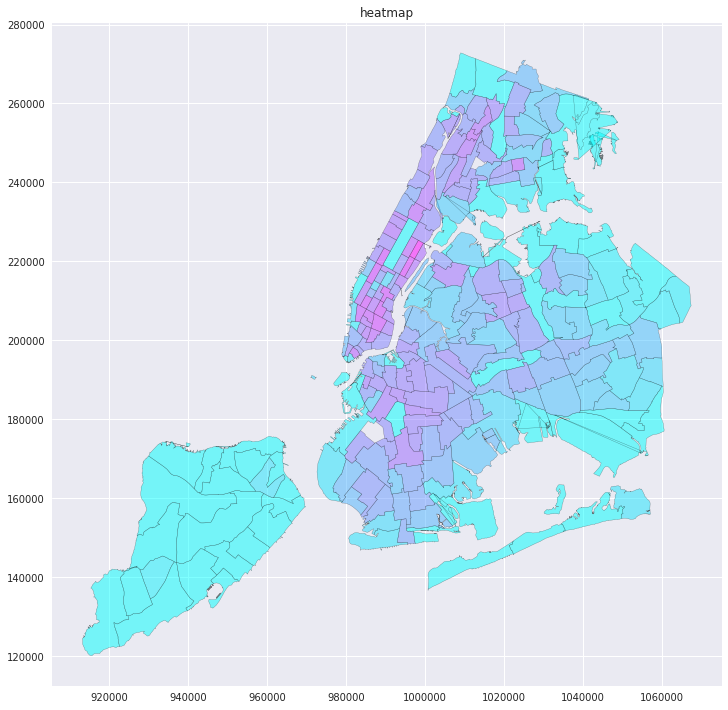

In [18]:
plot_on_map(tzs,SMdata,'totalLR',areaNorm=True,logScale=True)

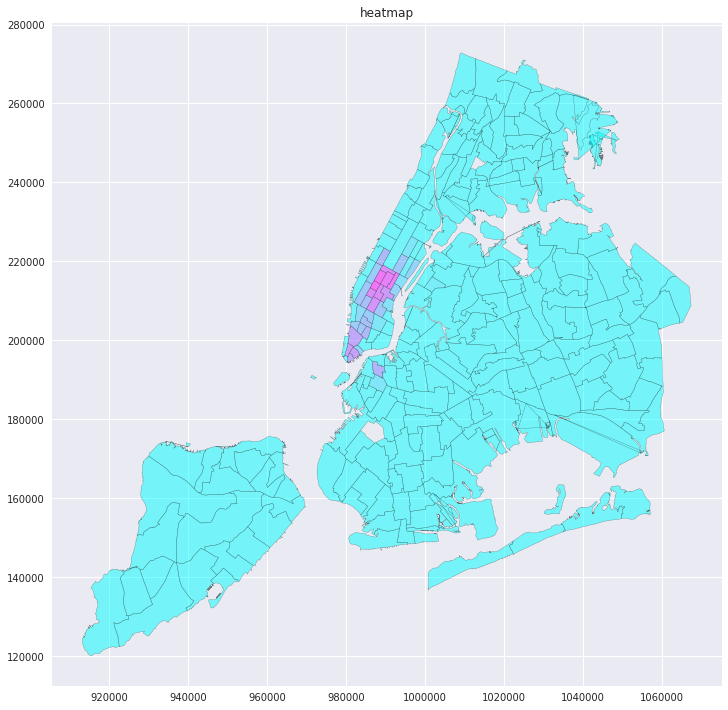

In [19]:
plot_on_map(tzs,SMdata,'totalLW',areaNorm=True,logScale=True)

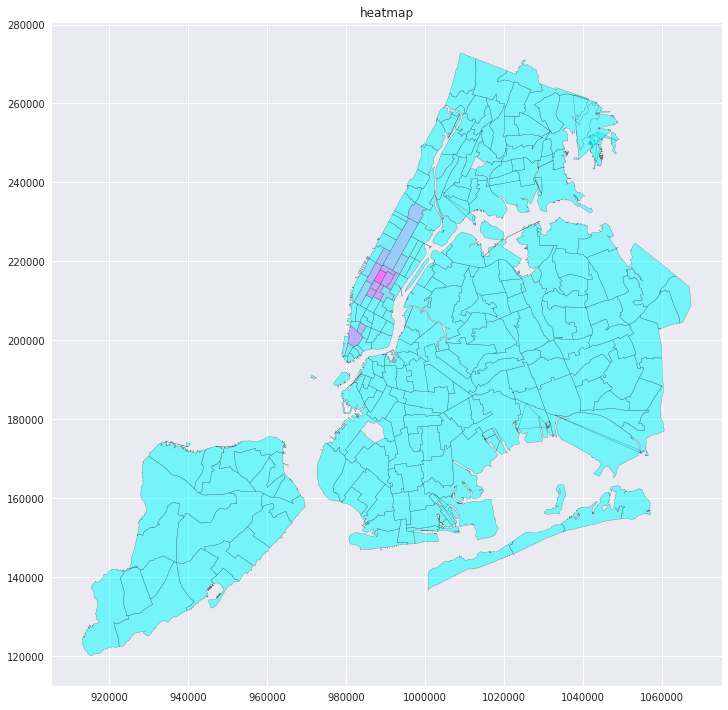

In [20]:
plot_on_map(tzs,SMdata,'twitter_spatial',areaNorm=True,logScale=True)

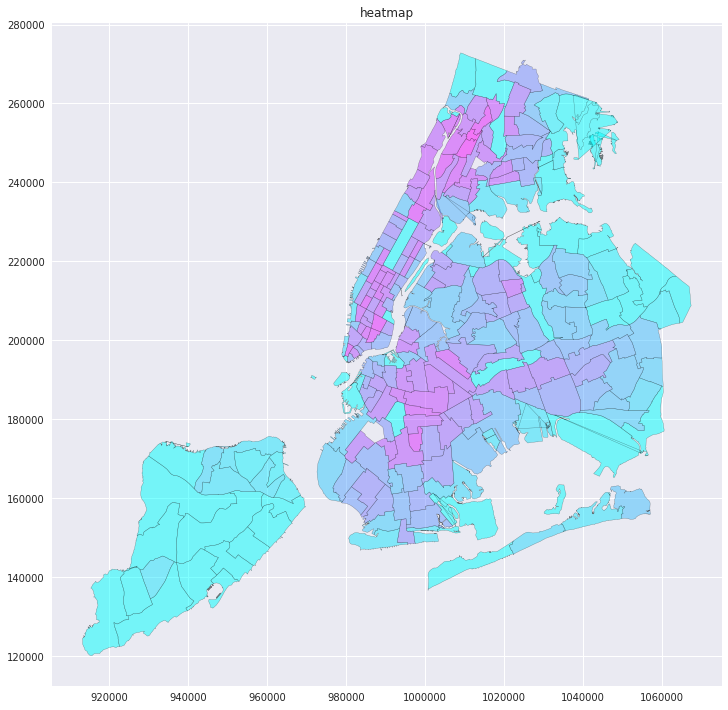

In [21]:
plot_on_map(tzs,SMdata,'sr311_spatial',areaNorm=True,logScale=True)

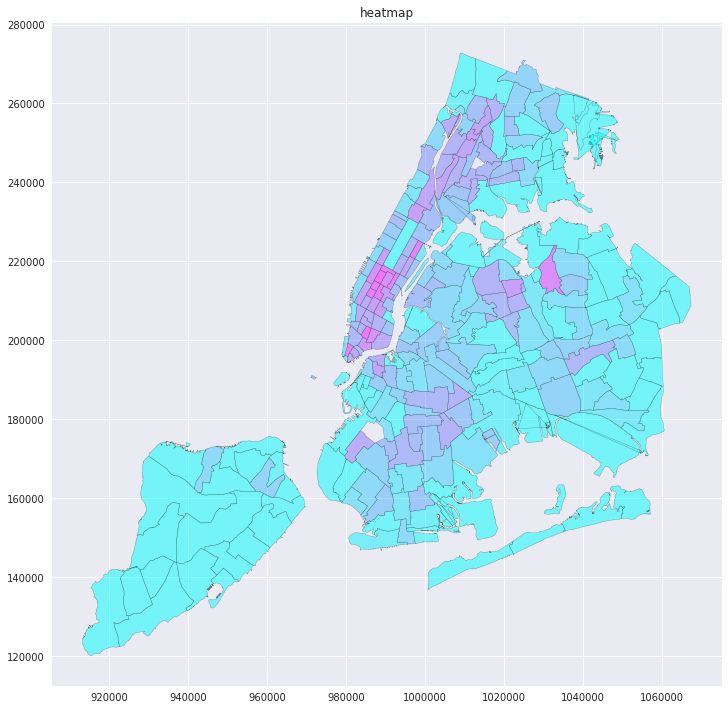

In [22]:
plot_on_map(tzs,SMdata,'mobile_spatial',areaNorm=True,logScale=True)

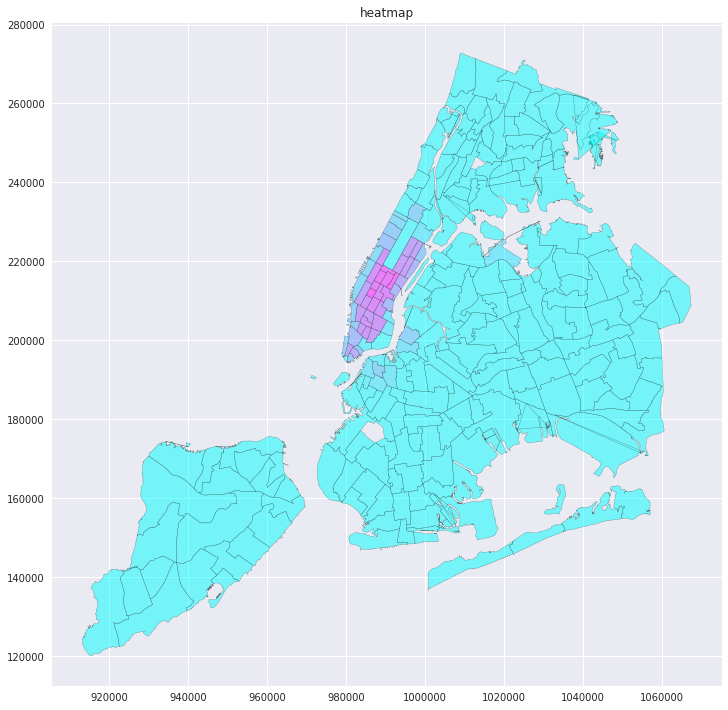

In [23]:
plot_on_map(tzs,SMdata,'taxi_spatial',areaNorm=True,logScale=True)

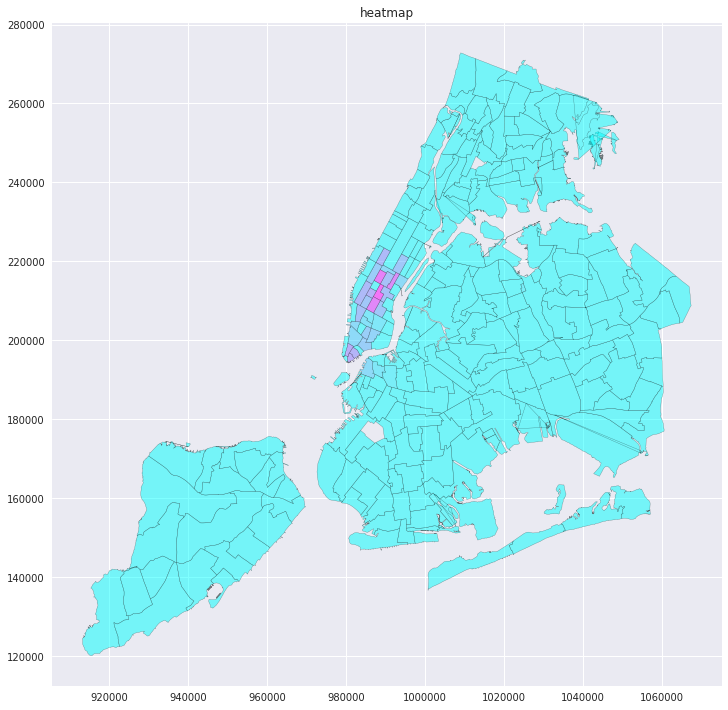

In [24]:
plot_on_map(tzs,SMdata,'subway_spatial',areaNorm=True,logScale=True)

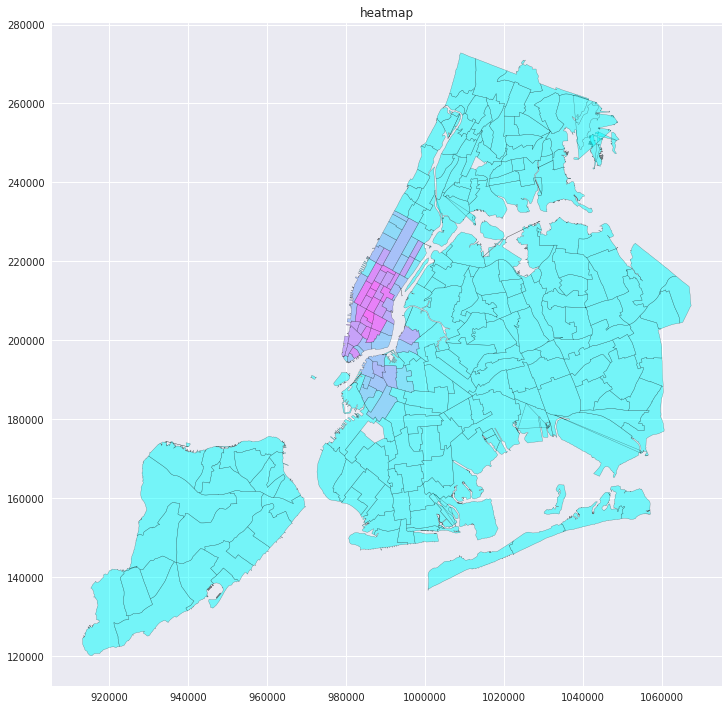

In [25]:
plot_on_map(tzs,SMdata,'citibike_spatial',areaNorm=True,logScale=True)

In [26]:
lm = smf.ols(formula='mobile_spatial~population-1', data = SMdata.loc[SMdata.mobile_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         mobile_spatial   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     885.2
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           4.60e-85
Time:                        20:56:55   Log-Likelihood:                -3488.8
No. Observations:                 257   AIC:                             6980.
Df Residuals:                     256   BIC:                             6983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
population     8.7441      0.294     29.753      0.0

### Uncertainty of regression estimates

While `coef` is what we care about in the first place (mobile activity per capita), output reports multiple other quantities, such as standard error and confidence interval for this estimate.

We'll get to there exact meaning later, but for now just a rough idea: regression is a probabilistic model, admitting uncertainty in both - the data itself as well as the resulting model estimates. The data could be noisy, or represent just a partial available sample of observations or account for other parameters, not directly observed (i.e. market share of the considered mobile operators or special event happening in certain areas might affect mobile activity pushing it above or below a reasonable model expectation, making such observations the outliers, introducing noise and uncertainty).

But as we do not know which observations are the outliers, what if we run the regression multiple times on different samples of observations? Resulting values for the slope coefficient will form a certain distribution, as one can see below. This distribution will have not only the mean value, which will be consistent with the regression estimate reported above, but also **standard error** and **confidence intervals** (e.g. the interval where 95% most probable values belong) could be defined for it. 

The **p-value** is roughly speaking - our degree of confidence that zero is the right value for the slope coefficient, i.e. that the given regressor is not essential for the model. It is defined by measuring the overall probability weight (or chance of occurance) of all values of the slope coefficient being no more likely than zero, according the probability distribution we obtain for them.

This experiment is implemented below. By no means it explains the classic way of assessing uncertainty in regression estimates (and actually if you change the sampling fraction you'll see how it affects the standard deviation), but gives an idea of where such uncertainty might come from. We'll get to the rigorous definitions later over the course of the class, for now it is just important to understand the idea.

In [27]:
W=[]
df=SMdata.loc[SMdata.mobile_spatial>0]
np.random.seed(2018)
for i in range(0,100):
    df1=df.sample(frac=0.65)
    lm = smf.ols(formula='mobile_spatial~population-1', data = df1).fit()
    W+=[lm.params.population]
W=np.array(W)
print ('w=%.4f+-%.4f'%(W.mean(), W.std()))

w=8.7644+-0.2848


The model also return R-squared - characteristic of the regression performance. However it is only correctly defined for the models with the intercept.

In [28]:
lm = smf.ols(formula='mobile_spatial~population', data = SMdata.loc[SMdata.mobile_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         mobile_spatial   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     210.4
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           3.56e-35
Time:                        20:56:55   Log-Likelihood:                -3480.8
No. Observations:                 257   AIC:                             6966.
Df Residuals:                     255   BIC:                             6973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8.076e+04   1.99e+04      4.066      0.0

**Now try multi-variate regression to see what type of population activities actually depend upon (caused???)**

In [29]:
lm = smf.ols(formula='mobile_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.mobile_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         mobile_spatial   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     474.4
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           1.17e-86
Time:                        20:56:55   Log-Likelihood:                -3481.5
No. Observations:                 257   AIC:                             6967.
Df Residuals:                     255   BIC:                             6974.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW        2.3152      0.420      5.518      0.0

** Exercise 1. ** Run similar regressions for all other quantities - sr311_spatial, taxi_spatial, subway_spatial, twitter_spatial, citibike_spatial - figuring out their relation with working and residential population

In [30]:
lm = smf.ols(formula='sr311_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.sr311_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          sr311_spatial   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1156.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):          5.67e-128
Time:                        20:56:55   Log-Likelihood:                -1807.3
No. Observations:                 255   AIC:                             3619.
Df Residuals:                     253   BIC:                             3626.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW       -0.0003      0.001     -0.480      0.6

In [31]:
lm = smf.ols(formula='taxi_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.taxi_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           taxi_spatial   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     279.9
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           6.01e-65
Time:                        20:56:55   Log-Likelihood:                -3426.8
No. Observations:                 256   AIC:                             6858.
Df Residuals:                     254   BIC:                             6865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW        6.6430      0.357     18.591      0.0

In [32]:
lm = smf.ols(formula='subway_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.subway_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         subway_spatial   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     149.1
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           9.51e-37
Time:                        20:56:55   Log-Likelihood:                -2564.0
No. Observations:                 156   AIC:                             5132.
Df Residuals:                     154   BIC:                             5138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW      119.8173      7.991     14.994      0.0

In [33]:
lm = smf.ols(formula='twitter_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.twitter_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        twitter_spatial   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     141.2
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           5.27e-42
Time:                        20:56:55   Log-Likelihood:                -2159.5
No. Observations:                 257   AIC:                             4323.
Df Residuals:                     255   BIC:                             4330.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW        0.0346      0.002     14.114      0.0

In [34]:
lm = smf.ols(formula='citibike_spatial~totalLW+totalLR-1', data = SMdata.loc[SMdata.citibike_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       citibike_spatial   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     54.48
Date:                Mon, 24 Sep 2018   Prob (F-statistic):           1.17e-15
Time:                        20:56:55   Log-Likelihood:                -975.11
No. Observations:                  82   AIC:                             1954.
Df Residuals:                      80   BIC:                             1959.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalLW        0.5034      0.085      5.919      0.0

** Excercise 2 ** Calculate and report pairwise correlations between all activities

a) where all exist;

b) where two exist for each pair.

c) Visualize a log-scale scatter plot for two activites having the highest correlation (according to a or b, whichever you prefer), taking only those taxi zones where both activities are present.

In [36]:
#a)

#mobile_spatial,sr311_spatial, taxi_spatial, subway_spatial, twitter_spatial, citibike_spatial

ind = (SMdata['mobile_spatial']>0)&(SMdata['sr311_spatial']>0)&(SMdata['taxi_spatial']>0)&(SMdata['subway_spatial']>0)&(SMdata['twitter_spatial']>0)&(SMdata['citibike_spatial']>0)

def NZPopCorrAll(col1,col2):
    return np.corrcoef(SMdata[col1][ind],SMdata[col2][ind])[0][1]

l1 = ['mobile_spatial','sr311_spatial', 'taxi_spatial', 'subway_spatial', 'twitter_spatial', 'citibike_spatial']
l2 = l1

print('    Activity    |{}\t|{}\t|{}\t|{}\t|{}\t|{}\t').format(l1[0],l1[1],l1[2],l1[3],l1[4],l1[5])
for A in l2:
    C=[]
    for P in l1:
        C+=[NZPopCorrAll(A,P)]   
    print('%16s | %.4f\t | %.4f\t | %.4f\t | %.4f\t | %.4f\t | %.4f\t |'% (A,C[0],C[1],C[2],C[3],C[4],C[5]))  

    Activity    |mobile_spatial	|sr311_spatial	|taxi_spatial	|subway_spatial	|twitter_spatial	|citibike_spatial	
  mobile_spatial | 1.0000	 | 0.5671	 | 0.1881	 | 0.2081	 | 0.3030	 | -0.0696	 |
   sr311_spatial | 0.5671	 | 1.0000	 | -0.0726	 | -0.1881	 | -0.0140	 | -0.1707	 |
    taxi_spatial | 0.1881	 | -0.0726	 | 1.0000	 | 0.5589	 | 0.4676	 | 0.5715	 |
  subway_spatial | 0.2081	 | -0.1881	 | 0.5589	 | 1.0000	 | 0.4024	 | 0.3060	 |
 twitter_spatial | 0.3030	 | -0.0140	 | 0.4676	 | 0.4024	 | 1.0000	 | 0.2491	 |
citibike_spatial | -0.0696	 | -0.1707	 | 0.5715	 | 0.3060	 | 0.2491	 | 1.0000	 |


In [37]:
#b)
l1 = ['mobile_spatial','sr311_spatial', 'taxi_spatial', 'subway_spatial', 'twitter_spatial', 'citibike_spatial']
l2 = l1

print('    Activity    |{}\t|{}\t|{}\t|{}\t|{}\t|{}\t').format(l1[0],l1[1],l1[2],l1[3],l1[4],l1[5])
for A in l2:
    C=[]
    for P in l1:
        C+=[NZPopCorr(A,P)]   
    print('%16s | %.4f\t | %.4f\t | %.4f\t | %.4f\t | %.4f\t | %.4f\t |'% (A,C[0],C[1],C[2],C[3],C[4],C[5]))

    Activity    |mobile_spatial	|sr311_spatial	|taxi_spatial	|subway_spatial	|twitter_spatial	|citibike_spatial	
  mobile_spatial | 1.0000	 | 0.6023	 | 0.1418	 | 0.1130	 | 0.2142	 | 0.0763	 |
   sr311_spatial | 0.6023	 | 1.0000	 | -0.0341	 | -0.1946	 | 0.0628	 | -0.0764	 |
    taxi_spatial | 0.1418	 | -0.0341	 | 1.0000	 | 0.6472	 | 0.5556	 | 0.6141	 |
  subway_spatial | 0.1130	 | -0.1946	 | 0.6472	 | 1.0000	 | 0.4597	 | 0.3060	 |
 twitter_spatial | 0.2142	 | 0.0628	 | 0.5556	 | 0.4597	 | 1.0000	 | 0.2773	 |
citibike_spatial | 0.0763	 | -0.0764	 | 0.6141	 | 0.3060	 | 0.2773	 | 1.0000	 |


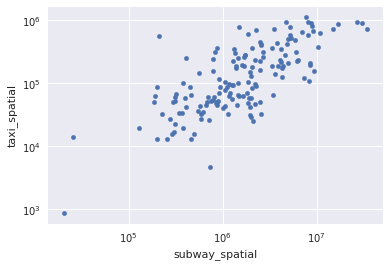

In [38]:
#c)
ind = (SMdata['taxi_spatial']>0)&(SMdata['subway_spatial']>0)
SMdata_2 = SMdata[ind]

SMdata_2.plot('subway_spatial','taxi_spatial',logx=True,logy=True,kind='scatter')

** Excercise 3. ** Run a regression with no intercept for the number of 311 service requests against:

a) education groups of residential population less_high_schoolLR,high_schoolLR,collegeLR,bachelorLR;

b) age groups of residential population age_under_29LR,age_30_54LR,age_55_overLR.

In [39]:
#a)
lm = smf.ols(formula='sr311_spatial~less_high_schoolLR+high_schoolLR+collegeLR+bachelorLR-1', data = SMdata.loc[SMdata.sr311_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          sr311_spatial   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     928.6
Date:                Mon, 24 Sep 2018   Prob (F-statistic):          4.42e-149
Time:                        20:57:57   Log-Likelihood:                -1750.7
No. Observations:                 255   AIC:                             3509.
Df Residuals:                     251   BIC:                             3524.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
less_high_schoolLR     0.1025      0

In [40]:
#b)
lm = smf.ols(formula='sr311_spatial~age_under_29LR+age_30_54LR+age_55_overLR-1', data = SMdata.loc[SMdata.sr311_spatial>0]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          sr311_spatial   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     917.3
Date:                Mon, 24 Sep 2018   Prob (F-statistic):          2.96e-135
Time:                        20:57:57   Log-Likelihood:                -1786.6
No. Observations:                 255   AIC:                             3579.
Df Residuals:                     252   BIC:                             3590.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
age_under_29LR     0.1830      0.025      7.

** Excercise 4 ** Visualize top 5 taxi zones by a) mobile activity per capita of residential population and b) taxi activity per capita of working population

In [47]:
SMdata['mobile_spatial_per_capita'] = SMdata['mobile_spatial']/SMdata['totalLR']
SMdata.loc[:,['mobile_spatial_per_capita','mobile_spatial','totalLR']].head()

,mobile_spatial_per_capita,mobile_spatial,totalLR
tz,,,
3,9.589402,109300,11398
4,14.583861,179644,12318
5,5.234025,56271,10751
6,21.945906,147674,6729
7,11.806704,508255,43048


In [48]:
SMdata['taxi_spatial_per_capita'] = SMdata['taxi_spatial']/SMdata['totalLW']
SMdata.loc[:,['taxi_spatial_per_capita','taxi_spatial','totalLW']].head()

,taxi_spatial_per_capita,taxi_spatial,totalLW
tz,,,
3,6.406093,31960,4989
4,65.702981,178515,2717
5,3.078925,3667,1191
6,2.988377,7456,2495
7,21.028857,362180,17223


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


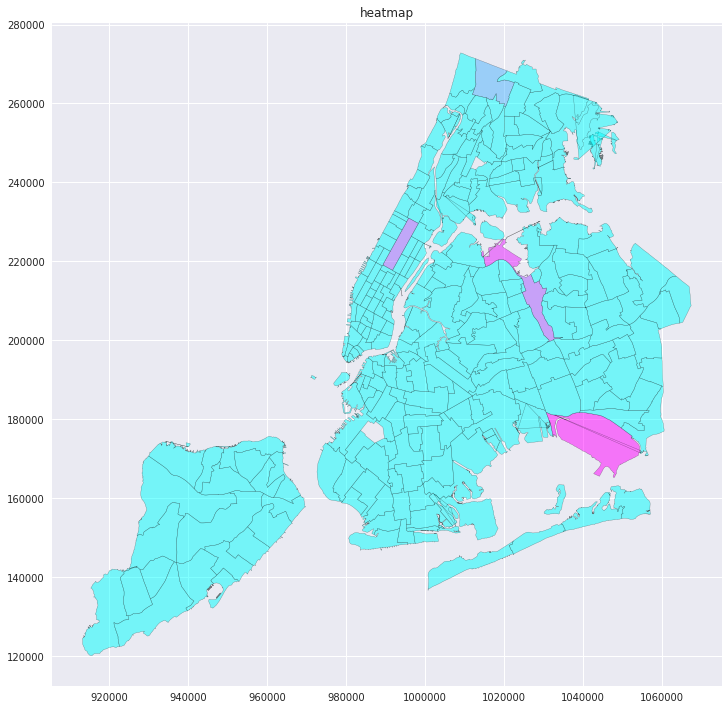

In [55]:
SMdata_mobile = SMdata.sort_values(by=['mobile_spatial_per_capita'],ascending=False,axis=0)
SMdata_mobile['mobile_spatial_per_capita'][5:] = 0 #to get only 5 zones
plot_on_map(tzs,SMdata_mobile,'mobile_spatial_per_capita',areaNorm=False,logScale=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


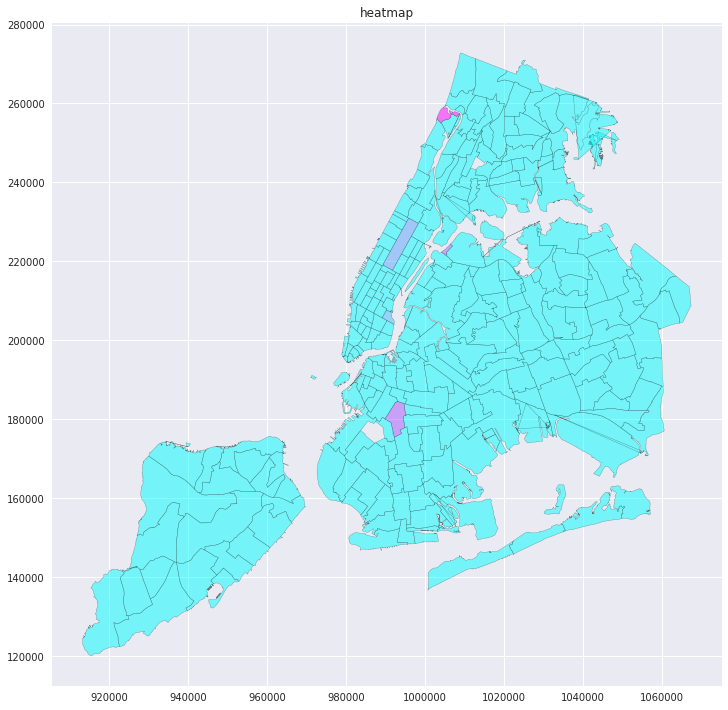

In [60]:
SMdata_taxi = SMdata.sort_values(by=['taxi_spatial_per_capita'],ascending=False,axis=0)
SMdata_taxi['taxi_spatial_per_capita'][5:] = 0 #to get only 5 zones
plot_on_map(tzs,SMdata_taxi,'taxi_spatial_per_capita',areaNorm=False,logScale=True)